In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.config import BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX

In [5]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [55]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plotxyze, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [7]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [8]:
from pymono.cnn_func import ResNet10

In [9]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX

- BGO crystal with Fano factor

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 4.5 k photons per point (BGO, with ~9 k photons/MeV)
- 2MHzDC 
- PTFE wrapping (all sides)
- LUT model
- Nexus simulation 

## Setup

In [11]:
crystal = BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX

In [293]:
data_path

NameError: name 'data_path' is not defined

In [12]:
imgs, mdata = select_image_and_lbl(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


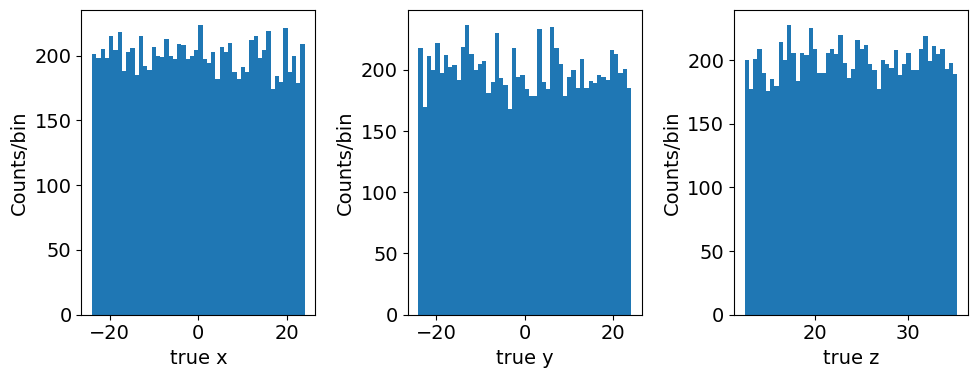

In [13]:
plot_true_positions(mdata)

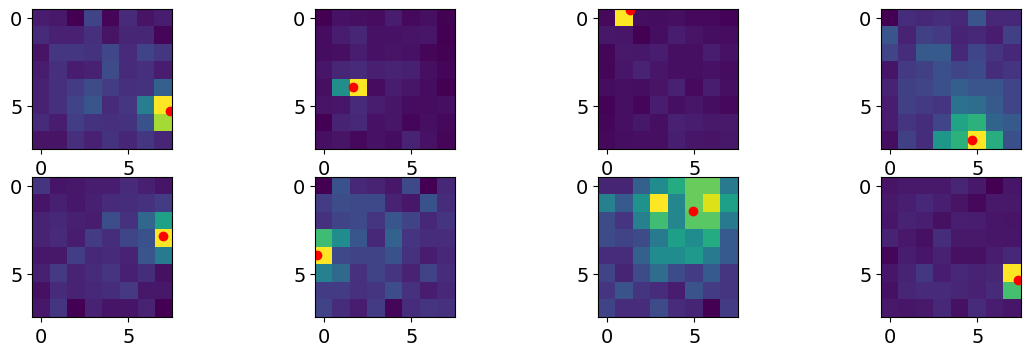

In [14]:
plot_images(imgs, mdata, range(0,8))

In [15]:
imgs[0]

array([[12., 11.,  6., 21.,  7., 15., 10., 12.],
       [15., 13., 13., 16., 10., 14., 14.,  7.],
       [10., 18., 18., 17., 22., 15., 21., 18.],
       [12., 16., 12., 13., 23., 15., 16., 12.],
       [13., 16., 19., 23., 19., 16., 17., 29.],
       [13., 16., 21., 26., 15., 18., 38., 81.],
       [15., 12., 20., 17., 16., 17., 25., 71.],
       [10., 10., 16., 13., 17., 14., 18., 14.]], dtype=float32)

In [16]:
np.mean(imgs[0])

17.796875

In [17]:
np.std(imgs[0])

11.715614

In [18]:
energy = get_energy(crystal, 9)

Selected files: img = images_10.npy, metdata = metadata_10.csv


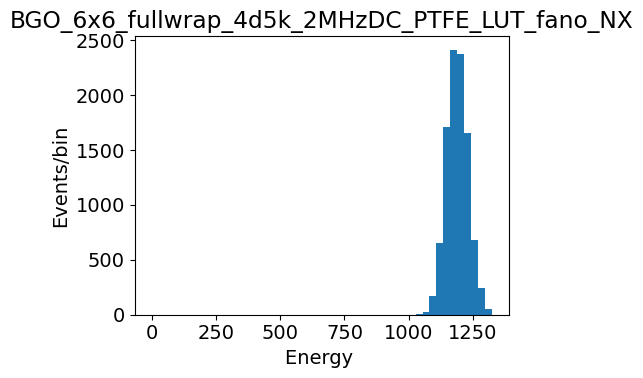

In [19]:
plot_energies2({"BGO_6x6_fullwrap_4d5k_2MHzDC_PTFE_LUT_fano_NX":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [20]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} sigma = {100*std6x6:.2f} % FWHM = {100*fwhm6x6:.2f} %")

mean = 1189.59 sigma = 3.48 % FWHM = 8.01 %


## Data set

In [21]:
first_file = 0  # initial file indx
last_file  = 30  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [37]:
# xyze = True for new data sets where the csv includes (x,y,z,nphot) but the network 
# compares with xyz. For old data sets (x,y,z) or new data sets comparing with a net of
# x,y,z,e output, use xyze = False (or remove, it is the default). 

dataset = MonoDataset(crystal, first_file, last_file, xyze=False)


Running Monoataset with norm = False, resize=False
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [38]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


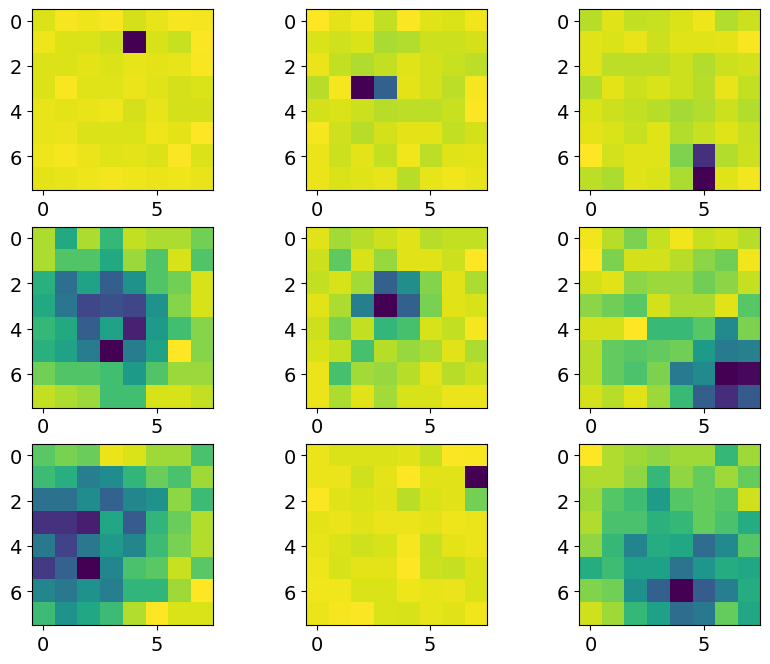

In [39]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [40]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 4])
tensor([[ 7., 12., 11., 14., 11., 11., 13., 11.],
        [12., 17., 16., 10., 14., 18., 12., 20.],
        [14., 23., 14., 15., 28., 18., 14., 15.],
        [10., 15., 20., 21., 13., 10.,  9.,  7.],
        [12., 24., 21., 19., 18., 14., 12., 10.],
        [27., 42., 53., 27., 17., 16., 16.,  5.],
        [37., 58., 52., 44., 10., 11., 20., 10.],
        [17., 28., 40., 20., 17.,  8., 11.,  7.]])


### Train the network with CNN_basic 

In [43]:
# Load the model.
model = CNN_3x3(dropout=False, energy=True).to(device)
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [44]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [45]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 4])
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 4])
outputs = torch.Size([1000, 4])
Train Step 1/700, Loss: 5054261.5
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 4])
outputs = torch.Size([1000, 4])
Train Step 2/700, Loss: 5063940.5


In [46]:
epochs = 10

In [47]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->10

EPOCH 0
Train Step 200/700, Loss: 4544866.5
Train Step 400/700, Loss: 3660200.0
Train Step 600/700, Loss: 2585561.25
Validation Step 200/200, Loss: 1922982.625
--- EPOCH 0 AVG TRAIN LOSS: 3780119.39375
--- EPOCH 0 AVG VAL LOSS: 1926362.539375

EPOCH 1
Train Step 200/700, Loss: 1151912.5
Train Step 400/700, Loss: 531305.3125
Train Step 600/700, Loss: 191219.6875
Validation Step 200/200, Loss: 99168.453125
--- EPOCH 1 AVG TRAIN LOSS: 803224.9403571428
--- EPOCH 1 AVG VAL LOSS: 99729.63640625

EPOCH 2
Train Step 200/700, Loss: 26376.671875
Train Step 400/700, Loss: 5721.59765625
Train Step 600/700, Loss: 1882.8668212890625
Validation Step 200/200, Loss: 1411.2020263671875
--- EPOCH 2 AVG TRAIN LOSS: 21562.14161324637
--- EPOCH 2 AVG VAL LOSS: 1326.0794854736328

EPOCH 3
Train Step 200/700, Loss: 1266.6376953125
Train Step 400/700, Lo

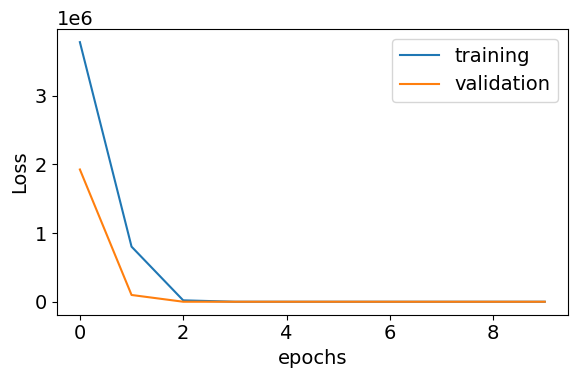

In [48]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [52]:
tdeltas = evaluate_cnn(test_loader, model, device, energy=True)

In [ ]:
#plot_true_predicted(tdeltas, nbins = 50)

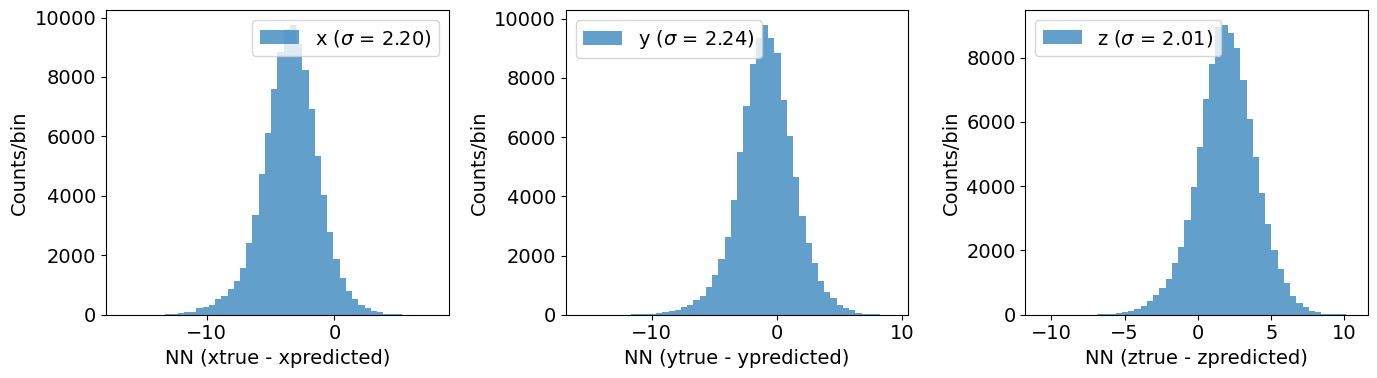

In [53]:
plotxyz(tdeltas, nbins=50)

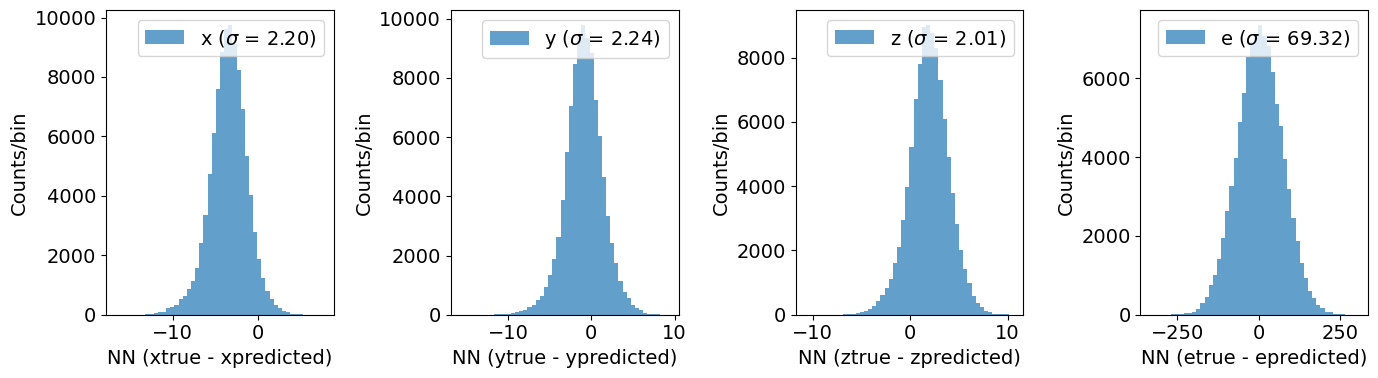

In [57]:
plotxyze(tdeltas, nbins=50)

In [69]:
69.32/mean6x6

0.05827219144271095

## Normalize

In [70]:
imean = 18.6
isigma = 5.0
dataset = MonoDataset(crystal, 
                      first_file, last_file,
                      norm=True, resize=False, mean=imean, std=isigma)


Running Monoataset with norm = True, resize=False
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [72]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


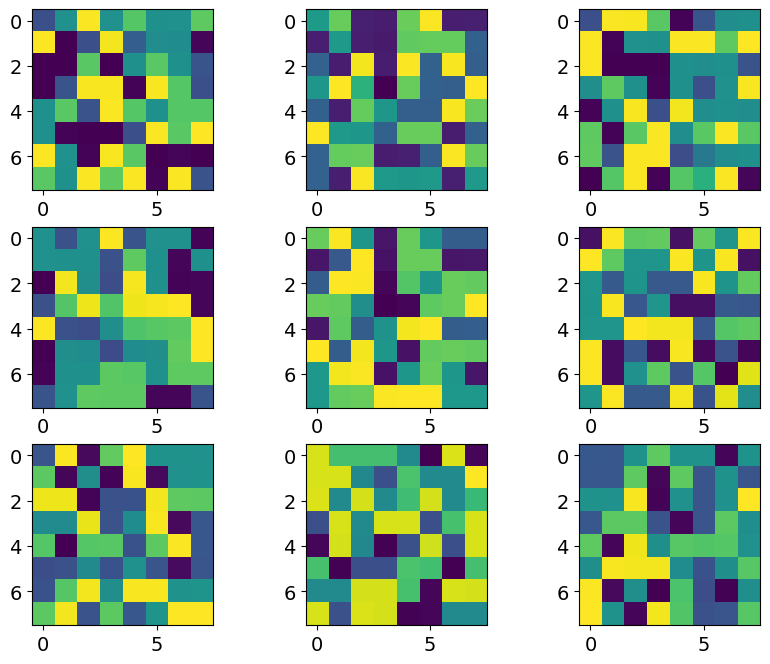

In [73]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [74]:
images, positions = next(iter(train_loader)) 
print(f"read image batch, size->{images.size()}")
img = images[0].squeeze()
print(img)

read image batch, size->torch.Size([1000, 1, 8, 8])
tensor([[-1.1200, -1.5200, -0.7200, -0.1200, -0.7200, -0.9200, -1.1200, -1.7200],
        [-1.5200, -1.7200, -1.5200,  0.0800, -1.1200, -0.1200, -1.1200, -2.3200],
        [-1.9200, -1.5200, -1.1200, -0.1200, -0.1200, -0.3200, -1.3200, -0.3200],
        [-1.3200, -1.7200, -0.1200,  1.2800, -0.3200, -0.3200, -0.3200, -0.1200],
        [-2.7200, -0.5200,  1.4800,  1.6800,  3.6800,  6.6800,  2.2800, -1.5200],
        [-0.1200, -0.3200,  0.4800, -0.5200,  7.0800,  9.2800,  6.2800,  0.4800],
        [-1.5200,  0.4800, -0.1200,  1.0800,  3.6800,  6.4800,  1.2800,  1.0800],
        [-2.3200, -1.1200, -0.7200, -1.1200, -2.1200, -0.5200, -0.5200, -0.3200]])


In [97]:
np.sum(img.numpy())

10.319998

In [75]:
model = CNN_3x3(dropout=False, energy=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [76]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 4])
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 4])
outputs = torch.Size([1000, 4])
Train Step 1/700, Loss: 5054490.0
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 4])
outputs = torch.Size([1000, 4])
Train Step 2/700, Loss: 5052189.5


In [77]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->10

EPOCH 0
Train Step 200/700, Loss: 4532010.0
Train Step 400/700, Loss: 3621294.5
Train Step 600/700, Loss: 2543237.75
Validation Step 200/200, Loss: 2009579.125
--- EPOCH 0 AVG TRAIN LOSS: 3753731.1025
--- EPOCH 0 AVG VAL LOSS: 2013624.24625

EPOCH 1
Train Step 200/700, Loss: 1109729.875
Train Step 400/700, Loss: 498313.53125
Train Step 600/700, Loss: 176453.609375
Validation Step 200/200, Loss: 93540.2578125
--- EPOCH 1 AVG TRAIN LOSS: 771377.4646986608
--- EPOCH 1 AVG VAL LOSS: 93695.73453125

EPOCH 2
Train Step 200/700, Loss: 23179.98828125
Train Step 400/700, Loss: 5093.4921875
Train Step 600/700, Loss: 1810.0438232421875
Validation Step 200/200, Loss: 1480.824462890625
--- EPOCH 2 AVG TRAIN LOSS: 19203.847105538505
--- EPOCH 2 AVG VAL LOSS: 1375.4537756347656

EPOCH 3
Train Step 200/700, Loss: 1333.2789306640625
Train Step 400

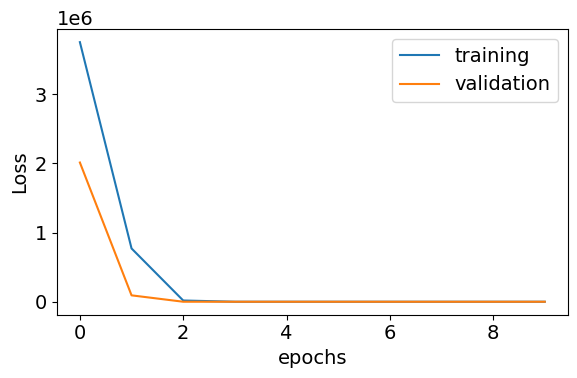

In [78]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))



In [79]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=True)

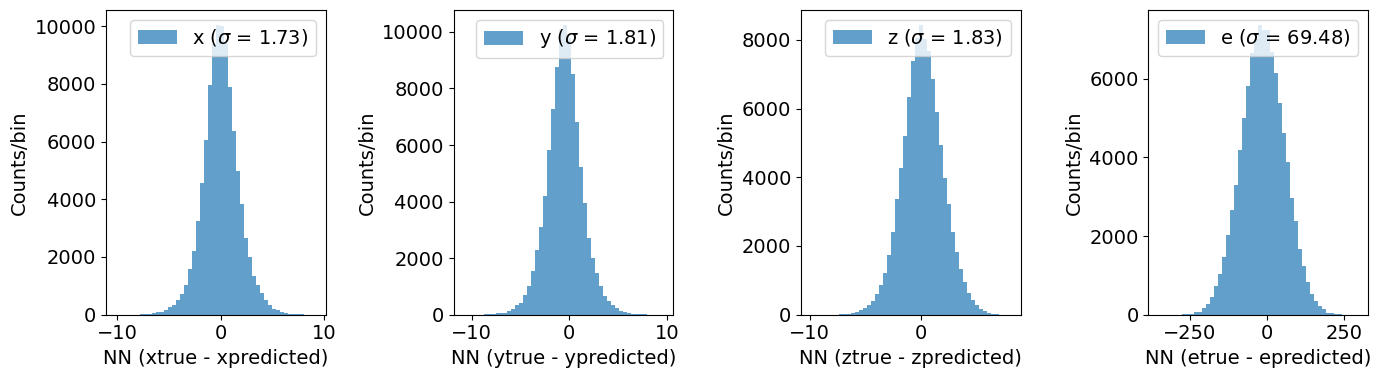

In [80]:
plotxyze(tdeltas, nbins=50)

### Normalization Improves resolution and eliminates bias. 

In [81]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2

In [82]:
dataset = MonoDataset(crystal, 
                      first_file, last_file,
                      norm=True, resize=False, mean=imean, std=isigma)


Running Monoataset with norm = True, resize=False
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [83]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [84]:
model = CNN_3x3(dropout=True, energy=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=4, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [85]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 4])
Train Step 200/700, Loss: 4574861.0
Train Step 400/700, Loss: 3726260.5
Train Step 600/700, Loss: 2679179.0
Validation Step 200/200, Loss: 2123320.0
--- EPOCH 0 AVG TRAIN LOSS: 3837070.8928571427
--- EPOCH 0 AVG VAL LOSS: 2127728.90875

EPOCH 1
Train Step 200/700, Loss: 1249532.25
Train Step 400/700, Loss: 594164.375
Train Step 600/700, Loss: 227009.8125
Validation Step 200/200, Loss: 120730.359375
--- EPOCH 1 AVG TRAIN LOSS: 869160.5542410715
--- EPOCH 1 AVG VAL LOSS: 121312.3125390625

EPOCH 

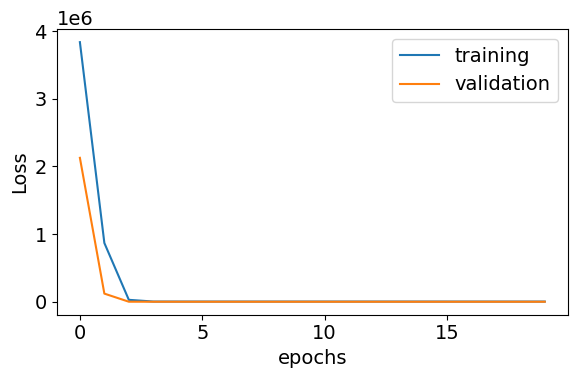

In [86]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [87]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6, energy=True)


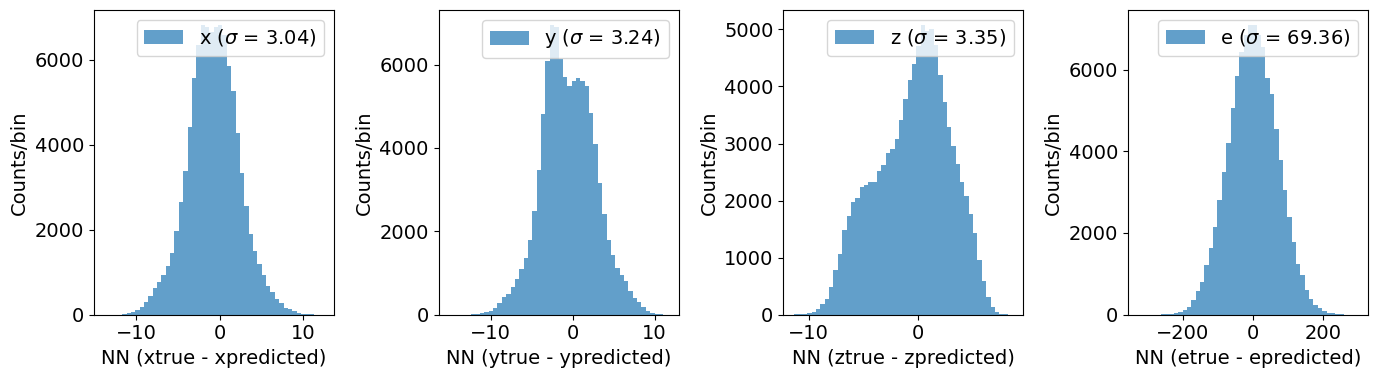

In [88]:
plotxyze(tdeltas, nbins=50)

## FF network

In [267]:
class FF(nn.Module):
    def __init__(self, dropout=False, dropout_fraction=0.2):
        # call constructor from superclass
        super().__init__()

        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)
        # define network layers
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        #self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(4, 1)
        
    def forward(self, x):
        # define forward pass
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        #x = torch.sigmoid(self.fc3(x))
        if self.dropout: x = self.drop1(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [269]:
ffmodel = FF(dropout=True).to(device)
print(ffmodel)
optimizer = optim.Adam(ffmodel.parameters(), lr=0.001)
criterion = nn.MSELoss()

FF(
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)


In [294]:
crystal

'/Users/jjgomezcadenas/data/monolith/BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX'

In [291]:
class FFMonoDataset(Dataset):
    """
    Loads the data to pytorch 
    self.dataset ->[d1, d2...] where di ->[(x,y,z,eobs), vector (etrue)]
    
    """

    def __init__(self, data_path: str, frst_file: int, lst_file: int,
                norm=False, xnorm=(24.0, 12.5, 35.3, 4700.0)):

        def normz(z):
            return (z - xnorm[1])/(xnorm[2] - xnorm[1])

        print(data_path)
        self.dataset = []
        img_name, lbl_name, indx = files_list_npy_csv(data_path)
        print(f"Loading files with indexes: {indx[frst_file:lst_file]}")

        ii = 0
        for i in indx[frst_file:lst_file]:
            images = np.load(f'{data_path}/{img_name}_{i}.npy')
            metadata = pd.read_csv(f'{data_path}/{lbl_name}_{i}.csv')
            
            for img, meta in zip(images, metadata.values):
                #ii=+1
                #print(f"img = {img}, sum = {np.sum(img)}")
                #print(f"meta = {meta}")
                xx = np.array([meta[1], meta[2], meta[3], np.sum(img)])
                yy = np.array(meta[4])

                if norm:
                    xx = np.array([meta[1]/xnorm[0], meta[2]/xnorm[0], normz(meta[3]), 
                                   np.sum(img/xnorm[3])])
                    yy = np.array(meta[4]/xnorm[3]) 
                self.dataset.append((xx,yy))
                #if ii >3 : break

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        xyze, etrue = self.dataset[idx]
        #print(f"xyze ={xyze}, etrue={etrue}")
        xyze = torch.tensor(xyze, dtype=torch.float)
        etrue = torch.tensor(etrue, dtype=torch.float).unsqueeze(0)

        return xyze, etrue

In [292]:
fdataset = FFMonoDataset(crystal, first_file, last_file)


/Users/jjgomezcadenas/data/monolith/BGO_6x6_fullwrap_4.5k_2MHzDC_PTFE_LUT_fano_NX
Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [184]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(fdataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
 

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [152]:
fdataset[0]

(tensor([ -17.7365,    5.6521,   35.2076, 1242.0000]), tensor([4499.]))

In [185]:
xyzeb, etb = next(iter(train_loader)) 
print(f"read xyze batch, size->{xyzeb.size()}")
print(f"read et batch, size->{etb.size()}")
xyze = xyzeb[0].squeeze()
et = etb[0].squeeze()
print(xyze)
print(et)

read xyze batch, size->torch.Size([1000, 4])
read et batch, size->torch.Size([1000, 1])
tensor([  14.7797,    9.3442,   30.8703, 1202.0000])
tensor(4578.)


In [202]:
def get_xyze_max(tl):
    def min_max(value, min, max):
        if value < min: 
            min = value
        if value > max: 
            max = value
        return min, max

    xmin, ymin, zmin = 1e+6, 1e+6, 1e+6
    xmax, ymax, zmax = -1e+6, -1e+6, -1e+6
    emin, emax = 1e+6, -1e+6
    etmin, etmax = 1e+6, -1e+6

    for i in range(30):
        xyzeb, etb = next(iter(train_loader))
    
        for xyzet in xyzeb:
            xyze = xyzet.squeeze()
            xmin, xmax = min_max(xyze[0].item(), xmin, xmax)
            ymin, ymax = min_max(xyze[1].item(), ymin, ymax)
            zmin, zmax = min_max(xyze[2].item(), zmin, zmax)
            emin, emax = min_max(xyze[3].item(), emin, emax)
        
        for ett in etb:
            et = ett.squeeze()
            etmin, etmax = min_max(etb[0].item(), etmin, etmax)
    return xmin, xmax, ymin, ymax, zmin, zmax, emin, emax, etmin, etmax


In [203]:
get_xyze_max(train_loader)

(-23.99976348876953,
 23.994667053222656,
 -23.99873924255371,
 23.999629974365234,
 12.500003814697266,
 35.298885345458984,
 1036.0,
 1366.0,
 4416.0,
 4676.0)

In [212]:
ndataset = FFMonoDataset(crystal, first_file, last_file, norm=True)

Loading files with indexes: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


In [213]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(ndataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
 

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [214]:
get_xyze_max(train_loader)

(-0.9998769760131836,
 0.9999869465827942,
 -0.9999812245368958,
 0.9999445676803589,
 1.1315789379295893e-05,
 0.9999535083770752,
 0.22106382250785828,
 0.2914893627166748,
 0.9257446527481079,
 0.9827659726142883)

In [215]:
def single_runf(train_loader, device, model, optimizer, criterion):
    print(f"** Run for 1 event**")

    for epoch in range(1):
        print(f"epoch = {epoch}")
    
        for i, (images, labels) in enumerate(train_loader):  
            if i>5: break
            print(f"i = {i}")
            print(f"xyze (shape) = {images.shape}")
            print(f"et (shape) = {labels.shape}")

            im0 = images[0]
            lbl0 = labels[0]

            print(f"xyze (0) = {im0}")
            print(f"et0  = {lbl0}")
            
            images = images.to(device)
            labels = labels.to(device)
            
            model.train()
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            print(f"outputs = {outputs.shape}")
            out0 = outputs[0]
            print(f"out0  = {out0}")

            loss = criterion(outputs, labels)
            
            # Backward and optimize
            
            loss.backward()
            optimizer.step()
    
            print(f"Train Step {i + 1}/{len(train_loader)}, Loss: {loss.data.item()}")


In [270]:
single_runf(train_loader, device, ffmodel, optimizer, criterion)

** Run for 1 event**
epoch = 0
i = 0
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([ 0.1136, -0.1998,  0.2426,  0.2568])
et0  = tensor([0.9779])
outputs = torch.Size([1000, 1])
out0  = tensor([0.4551], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 1/700, Loss: 0.18365958333015442
i = 1
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([ 0.0620, -0.2264,  0.2101,  0.2606])
et0  = tensor([0.9253])
outputs = torch.Size([1000, 1])
out0  = tensor([0.5693], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 2/700, Loss: 0.18391484022140503
i = 2
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size([1000, 1])
xyze (0) = tensor([0.8673, 0.4111, 0.0045, 0.2604])
et0  = tensor([0.9549])
outputs = torch.Size([1000, 1])
out0  = tensor([0.4481], device='mps:0', grad_fn=<SelectBackward0>)
Train Step 3/700, Loss: 0.18254221975803375
i = 3
xyze (shape) = torch.Size([1000, 4])
et (shape) = torch.Size(

In [271]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    ffmodel, optimizer, device, criterion, 
                                    batch_size, epochs=3, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->3

EPOCH 0
Train Step 200/700, Loss: 0.0736604854464531
Train Step 400/700, Loss: 0.032763995230197906
Train Step 600/700, Loss: 0.017916176468133926
Validation Step 200/200, Loss: 0.00788025837391615
--- EPOCH 0 AVG TRAIN LOSS: 0.05725656814873219
--- EPOCH 0 AVG VAL LOSS: 0.007970897513441742

EPOCH 1
Train Step 200/700, Loss: 0.009171810932457447
Train Step 400/700, Loss: 0.005567071959376335
Train Step 600/700, Loss: 0.004640830215066671
Validation Step 200/200, Loss: 0.0007959511713124812
--- EPOCH 1 AVG TRAIN LOSS: 0.007302959158550948
--- EPOCH 1 AVG VAL LOSS: 0.0008159817813429981

EPOCH 2
Train Step 200/700, Loss: 0.0030345504637807608
Train Step 400/700, Loss: 0.0023304761853069067
Train Step 600/700, Loss: 0.0024314471520483494
Validation Step 200/200, Loss: 0.00030022705323062837
--- EPOCH 2 AVG TRAIN LOSS: 0.0027126971364

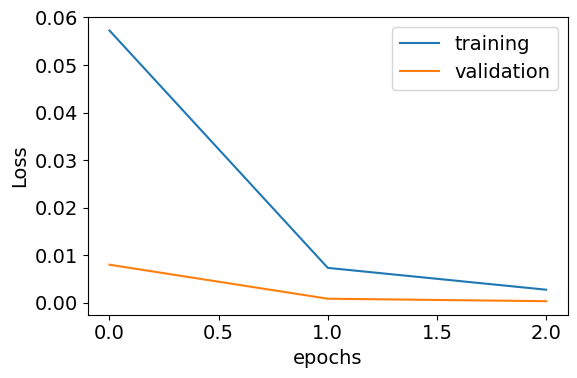

In [272]:
plot_loss(3, train_losses, val_losses,figsize=(6, 4))

In [223]:
def evaluate_ff(test_loader, model, device):
    
    true_e = []
    meas_e = []
    predicted_e = []
    
    with torch.no_grad():
        model.eval()
        for i, (xyze, et) in enumerate(train_loader): 
            
            for e in xyze[:,3]: meas_e.append(e)
            for e in et[:,0]: true_e.append(e)
                
            xyze = xyze.to(device)
            outputs = model(xyze).cpu()
            
            for e in outputs[:,0]: predicted_e.append(e)
            
    true_e = np.array(true_e); meas_e = np.array(meas_e); predicted_e = np.array(predicted_e)
    delta_e_NN = true_e - predicted_e
    return true_e, meas_e, predicted_e, delta_e_NN



In [273]:
true_e, meas_e, predicted_e, delta_e_NN = evaluate_ff(test_loader, ffmodel, device)

In [274]:
predicted_e[0:10]

array([0.95820516, 0.95794284, 0.9575551 , 0.9581106 , 0.9580249 ,
       0.95704156, 0.9574937 , 0.957892  , 0.95735997, 0.95809835],
      dtype=float32)

In [275]:
delta_e_NN[0:10]

array([-0.00182217, -0.01219815,  0.02372146, -0.00981271,  0.0113368 ,
        0.01657546,  0.00357008,  0.00976759, -0.01076424,  0.01913571],
      dtype=float32)

In [276]:
true_e[0:10]

array([0.956383  , 0.9457447 , 0.9812766 , 0.94829786, 0.9693617 ,
       0.973617  , 0.9610638 , 0.9676596 , 0.9465957 , 0.97723407],
      dtype=float32)

In [285]:
def sigmaEovE(xe, emax = 4700.0):
    mu = np.mean(xe * emax)
    sigma = np.std(xe * emax)
    return mu, sigma, 100 * sigma/mu, 2.355 * 100 * sigma/mu

In [286]:
sigmaEovE(true_e)

(4499.421, 81.12774, 1.803070679180285, 4.246231449469572)

In [287]:
sigmaEovE(meas_e)

(1190.1156, 41.075024, 3.4513473843129447, 8.127923090056985)

In [288]:
sigmaEovE(predicted_e)

(4500.2266, 2.3610866, 0.05246594975137699, 0.12355731166449281)

In [279]:
def xe(true_e, meas_e, predicted_e, delta_e_NN, emax = 4700.0, nbins=50):
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 7))
    flat_axes = axes.ravel()
    ax0, ax1, ax2, ax3 = flat_axes[0], flat_axes[1], flat_axes[2], flat_axes[3]
    
    ax0.hist(true_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(true_e):.3f})", alpha=0.7)
    ax0.set_xlabel("True energy",fontsize=14)
    ax0.set_ylabel("Counts/bin",fontsize=14)
    ax0.legend()

    ax1.hist(meas_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(meas_e):.3f})", alpha=0.7)
    ax1.set_xlabel("Measured energy",fontsize=14)
    ax1.set_ylabel("Counts/bin",fontsize=14)
    ax1.legend()

    ax2.hist(predicted_e * emax, bins=nbins, 
             label=f"x ($\sigma$ = {np.std(predicted_e):.3f})", alpha=0.7)
    ax2.set_xlabel("Predicted energy",fontsize=14)
    ax2.set_ylabel("Counts/bin",fontsize=14)
    ax2.legend()
    
    ax3.hist(delta_e_NN * emax, bins=nbins, 
             label=f"y ($\sigma$ = {np.std(delta_e_NN):.3f})", alpha=0.7)
    ax3.set_xlabel("NN (etrue - epredicted)",fontsize=14)
    ax3.set_ylabel("Counts/bin",fontsize=14)
    ax3.legend()
    
    fig.tight_layout()
    plt.show()

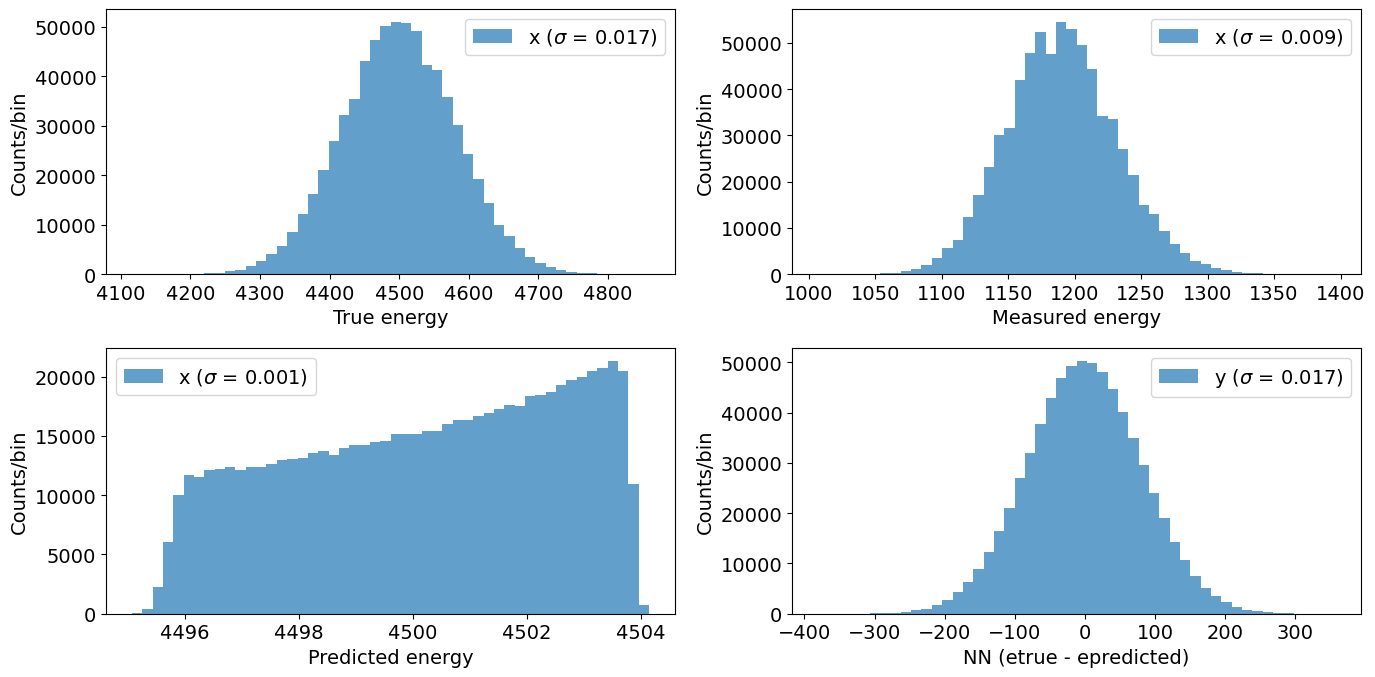

In [280]:
xe(true_e, meas_e, predicted_e, delta_e_NN, nbins=50)

### Deeper network

In [ ]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [ ]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [ ]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

In [ ]:
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
single_run(train_loader, device, model, optimizer,criterion)

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
plotxyz(tdeltas, nbins=50)

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 250  # Batch size
train_fraction=0.7 
val_fraction=0.2
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


In [ ]:
model = ResNet10(ResBlock, debug=False, dropout=True, dropout_fraction=0.2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=batch_size, epochs=10, iprnt=400)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

## Calculation of means

In [58]:
means, stds = get_means_stds(dir=crystal)

files in dir: 100
shape -> (10000, 8, 8)
mean img0 =19.40625
std  img0 =25.696372985839844


In [59]:
len(means)

100

In [60]:
means[0][0]

19.40625

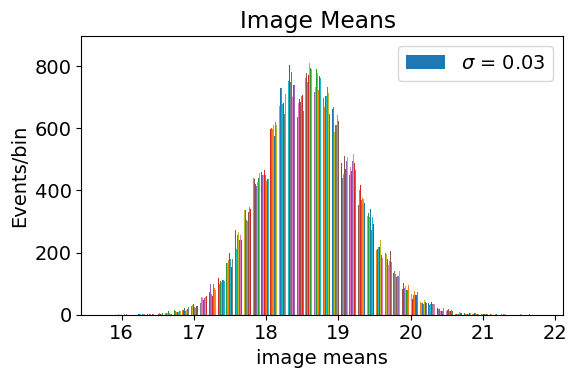

In [61]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [62]:
meansx =[np.mean(x) for x in means]

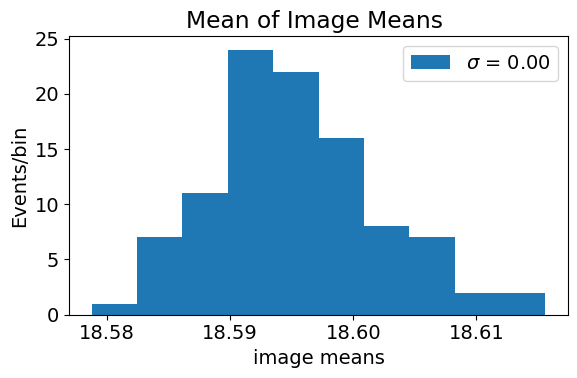

In [63]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [64]:
np.mean(meansx)

18.595125

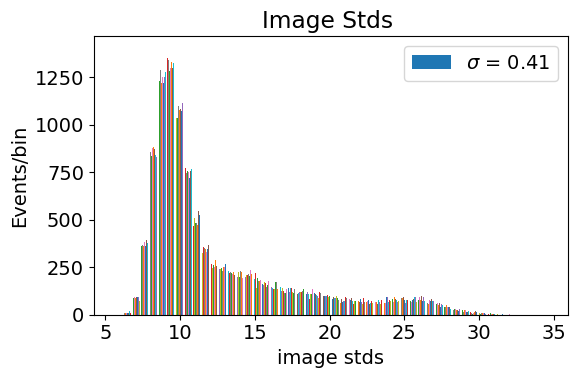

In [65]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [66]:
stdsx =[np.std(x) for x in stds]

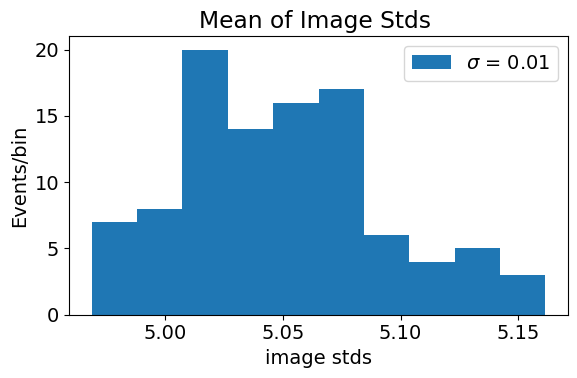

In [67]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [68]:
np.mean(stdsx)

5.0496707